In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from tqdm import tqdm
import wandb
import os
import gym
from train_ppo import train_ppo
from models.ppo import PPO
from env.wei_obs_grid import WeightedObsGrid
from utils.utils import uniform_weight, normal_weight, NormalWeightGrid
import pickle
from baseline.dijkstra import dijkstra_grid_with_weights, reconstruct_path
import copy
from models.dqn import D3QN


## Load Env

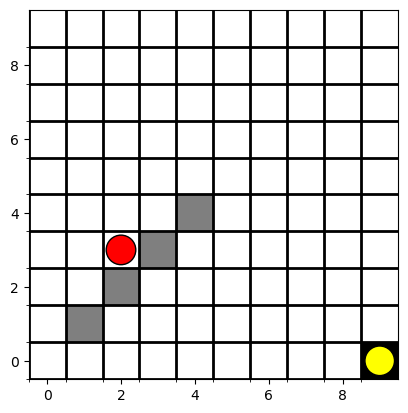

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [49]:
env = pickle.load(open('env_end_rand.pkl', 'rb'))
env.render()
print(env.state['obstacles'])

In [50]:
#grid_wei = copy.deepcopy(env.wei_reset.get_mean_std()[0])
grid_wei = copy.deepcopy(env.state['weight'])
for i in env.obstacles:
    grid_wei[i] = float('inf')
start = env.goal
end = env.start
env.goal_set = None

In [51]:
def run_dijkstra(grid_wei, start, end):
    dis, pred = dijkstra_grid_with_weights(grid_wei,start,end)
    path = reconstruct_path(pred, end)
    path.reverse()
    return dis, path

## Load Model

In [52]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 5000
hidden_dim = 3
gamma = 0.9
epsilon = 0.2
lmbda = 0.9
epochs = 10
reset_interval = 5000
max_steps = 500
state_dim = (4, env.grid_size[0], env.grid_size[1])
action_dim = 4
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, epsilon, lmbda, epochs, device='cuda:0')
agent.load_state_dict(torch.load('saved_model/ppo_model_milp.pth'))

<All keys matched successfully>

## Test Greedy-DRL-PPO

In [53]:
dijk_cost_list = []
ppo_cost_list = []
for _ in range(100):
    dis, path = run_dijkstra(grid_wei, start, end)
    
    for _ in range(5):
        done = False
        iter_num = 0
        ppo_cost = 0
        dijk_cost = 0
        state = env.reset()
        dijk_idx = 0
        while not done:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action_eval(state, eligibles,strategy='greedy')
            next_state, reward, done, _ = env.step(action)
            state = next_state

            ppo_cost += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
            if dijk_idx < len(path):
                dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
                dijk_idx += 1
        while dijk_idx < len(path):
            dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
            dijk_idx += 1
        dijk_cost_list.append(dijk_cost)
        ppo_cost_list.append(ppo_cost)


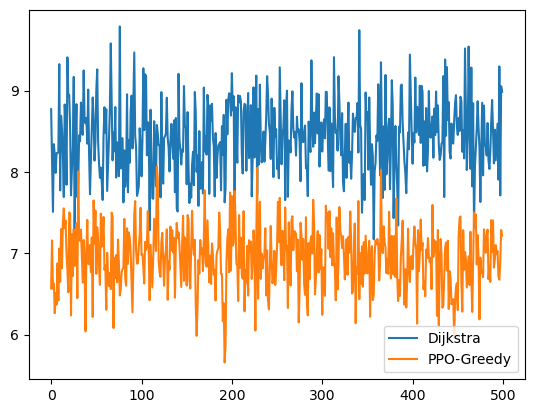

In [54]:
plt.plot(dijk_cost_list, label='Dijkstra')
plt.plot(ppo_cost_list, label='PPO-Greedy')
plt.legend()

In [55]:
import pandas as pd
df = pd.DataFrame({'Dijkstra': dijk_cost_list, 'PPO-Greedy': ppo_cost_list})
print(df.describe().to_markdown())

|       |   Dijkstra |   PPO-Greedy |
|:------|-----------:|-------------:|
| count | 500        |   500        |
| mean  |   8.42326  |     6.94982  |
| std   |   0.453649 |     0.378387 |
| min   |   7.17239  |     5.65816  |
| 25%   |   8.125    |     6.7049   |
| 50%   |   8.42063  |     6.97818  |
| 75%   |   8.74317  |     7.18957  |
| max   |   9.78731  |     8.0636   |


## Test Sample-DRL-PPO

In [56]:
dijk_cost_list = []
ppo_cost_list = []
for _ in range(100):
    dis, path = run_dijkstra(grid_wei, start, end)
    
    for _ in range(5):
        done = False
        iter_num = 0
        ppo_cost = 0
        dijk_cost = 0
        state = env.reset()
        dijk_idx = 0
        while not done:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action_eval(state, eligibles,strategy='greedy')
            next_state, reward, done, _ = env.step(action)
            state = next_state

            ppo_cost += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
            if dijk_idx < len(path):
                dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
                dijk_idx += 1
        while dijk_idx < len(path):
            dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
            dijk_idx += 1
        dijk_cost_list.append(dijk_cost)
        ppo_cost_list.append(ppo_cost)


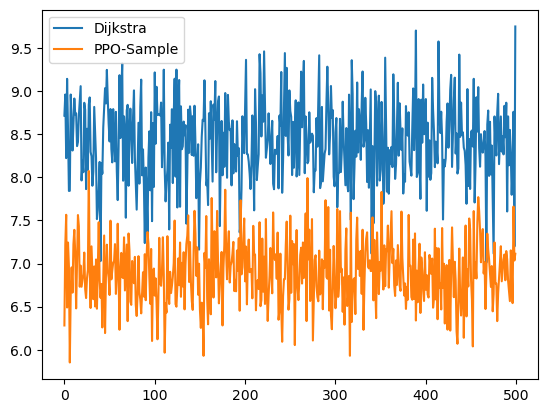

In [57]:
plt.plot(dijk_cost_list, label='Dijkstra')
plt.plot(ppo_cost_list, label='PPO-Sample')
plt.legend()

In [58]:
import pandas as pd
df = pd.DataFrame({'Dijkstra': dijk_cost_list, 'PPO-Sample': ppo_cost_list})
print(df.describe().to_markdown())

|       |   Dijkstra |   PPO-Sample |
|:------|-----------:|-------------:|
| count | 500        |   500        |
| mean  |   8.42166  |     6.89919  |
| std   |   0.467417 |     0.372591 |
| min   |   7.01112  |     5.85192  |
| 25%   |   8.11018  |     6.63735  |
| 50%   |   8.44246  |     6.89039  |
| 75%   |   8.75463  |     7.14495  |
| max   |   9.75013  |     8.07372  |


## Test Her-D3QN

In [59]:
grid_size = (10, 10)
lr = 1e-5
num_episodes = 5000
case_num = 1
hidden_dim = 3
gamma = 0.9
epsilon_explore = 0.99
epsilon = 0
epsilon_decay = 1
epochs = 10
target_update = 50
buffer_size = 10000
minimal_size = 50
batch_size = 256
reset_interval = 200  # 新增的超参数，设置每隔多少个 episode 重置一次环境
max_steps = 500  # 设置每个 episode 的最大步数，防止死循环
seed =42
device = 'cuda:3'
agent = D3QN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon_explore, epsilon_decay, target_update, device)
agent.load_state_dict(torch.load('saved_model/her_dij.pth'))

<All keys matched successfully>

In [63]:
dijk_cost_list = []
her_cost_list = []
for _ in range(100):
    dis, path = run_dijkstra(grid_wei, start, end)
    
    for _ in range(5):
        done = False
        iter_num = 0
        ppo_cost = 0
        dijk_cost = 0
        state = env.reset()
        dijk_idx = 0
        iter_num = 0
        while not done and iter_num < 20:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action(state, eligibles)
            next_state, reward, done, _ = env.step(action)
            state = next_state

            ppo_cost += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
            if dijk_idx < len(path):
                dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
                dijk_idx += 1
        while dijk_idx < len(path):
            dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
            dijk_idx += 1
        dijk_cost_list.append(dijk_cost)
        her_cost_list.append(ppo_cost)

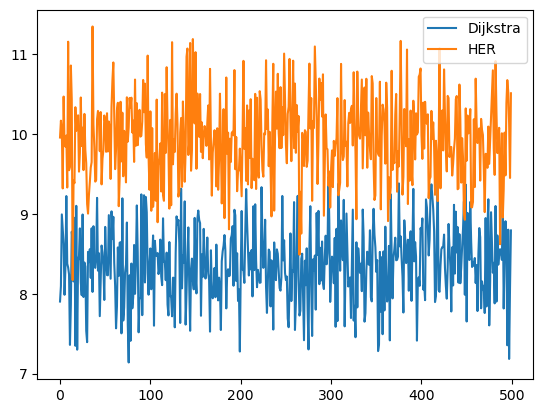

In [66]:
plt.plot(dijk_cost_list, label='Dijkstra')
plt.plot(her_cost_list, label='HER')
plt.legend()

In [65]:
df = pd.DataFrame({'Dijkstra': dijk_cost_list, 'HER': her_cost_list})
print(df.describe().to_markdown())

|       |   Dijkstra |        HER |
|:------|-----------:|-----------:|
| count | 500        | 500        |
| mean  |   8.3695   |   9.94495  |
| std   |   0.465164 |   0.516272 |
| min   |   7.13859  |   8.17006  |
| 25%   |   8.08115  |   9.58946  |
| 50%   |   8.38616  |   9.94999  |
| 75%   |   8.67102  |  10.2897   |
| max   |   9.45491  |  11.3461   |
